Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list anyone you collaborated with on this workbook

## Lab 9: Model selection and regularization

**This lab was distributed the week of October 26th and should be completed by *Wednesday* 11/04/2020 at 11:59PM.**

Welcome to Lab 9!

In this lab, we'll cover model selection and regularization (ISLR 6.1-6.2). Before we get into that, let's review what we've done so far in terms of modeling:
* in Labs 5-6, we covered linear regression by using ordinary least-squares (OLS) optimization to find the intercept and slope coefficient for a a linear relationship
* in Lab 7, we covered gradient descent, which is a way to find the coefficients of a model (in our case, a linear model) by iteratively calculating the coefficients using the gradient (the partial derivative of the model loss with respect to the coefficient) until we find a set of coefficients that minimize the loss function
* in Lab 8, we covered cross-validation, which is a way to find out how well a model trained on certain data performs when tested on new data

Model selection and regularization relate in some way to all of these topics. Model selection and regularization approaches give us a method to select which variables (i.e. features) to include in our model, as well as to select the value of the coefficients that should be associated with those variables. Cross-validation also allows us to select variables by providing a way to compare error across different models. 

Model selection and regularization are also related to OLS in that they provide different methods for choosing model coefficients. Rather than just minimizing the loss, techniques like Ridge or Lasso regression add a regularization term that penalizes the model if it includes too many features by pushing some of the coefficients to zero or close to zero.

Regularization methods like Ridge or Lasso can also work *with* cross-validation - for instance, in this lab, we're going to use cross-validation to tune the hyperparameter $\lambda$. We will use a random train-test split of the data to see how models with different values of $\lambda$ perform. Although we don't do it in this lab, a more systematic and rigorous way of evaluating different values of $\lambda$ would be to compare model performance using leave one out or k-fold cross validation.

In this lab, we'll focus on Ridge and Lasso regression, focusing on how to implement them and examining their prediction error and the coefficients that result from using these methods.

### Setup

In [2]:
# Run this block.
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

### Section 1: EDA and data filtering

You will be working with the Novotny et al. land-use regression dataset used in HW6.  Here's a refresher about the data:

* The data is an accumulation of GIS land-use characteristics from EPA land-monitoring and in situ NO2 measurements from satellite sensors.
* The goal of land-use regression (LUR) is to estimate outdoor air pollution geospatially across the contiguous United States.
* The reason for the high number of data points is that the data keeps track of readings from monitors at a high resolution, up to ~30 meters.

In [3]:
#run to load the dataset we'll be working with
df = pd.read_csv('data/BechleLUR_2006_allmodelbuildingdata.csv')

In [4]:
df.head()

,Monitor_ID,State,Latitude,Longitude,Observed_NO2_ppb,Predicted_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
0,04-013-0019-42602-1,AZ,33.48385,-112.14257,23.884706,20.986643,11.615223,313.0,0.304,59.4431,59.4715,59.4810,59.4572,59.3039,59.1636,59.0507,58.9488,58.7941,58.9821,59.2879,59.8456,60.1169,60.1553,59.7722,59.5908,59.5556,59.2200,58.3484,57.5475,56.3765,52.2642,3434.0000,3434.0000,3411.8328,3369.4805,3374.2180,3403.9201,3425.0499,3440.4236,3467.5636,3496.6767,3507.2187,3388.9482,3306.8511,3096.9563,2870.9081,2712.0688,2652.9409,2541.2515,2428.1611,2337.5601,2245.5723,2024.5460,0.00000,0.00000,0.00000,0.00000,0.49224,0.84872,1.11154,1.35858,3.48036,6.72288,10.45728,17.17240,21.46712,31.77685,50.76791,79.74268,104.89995,166.58362,231.04656,298.41773,384.37428,554.79507,0.61637,1.76406,3.64989,6.05967,9.08376,12.49667,16.72079,20.95306,28.19335,36.77423,56.07123,76.17936,92.75979,141.40171,208.14918,277.49442,360.92204,560.02672,803.90089,1089.93658,1404.00587,2083.12410,2269.08304,2454.55438,2635.14164,2843.33267,3069.31560,3254.15743,3433.87888,3623.34585,0.61637,1.76406,3.64989,6.05967,9.57600,13.34539,17.83233,22.31164,31.67371,43.49711,66.52851,93.35176,114.22691,173.17856,258.91709,357.23710,465.82199,726.61034,1034.94745,1388.35431,1788.38015,2637.91917,2862.73591,3096.99468,3339.22952,3609.20650,3896.25748,4150.54739,4396.96011,4651.18890
1,04-013-3002-42602-6,AZ,33.45793,-112.04601,25.089886,20.990096,11.472677,323.8,0.304,72.0000,72.0000,72.0000,72.0000,71.9109,71.6594,71.4787,71.4093,71.4899,71.6481,71.9319,71.8449,71.2728,69.4570,68.0373,66.6440,65.7764,63.4799,60.5909,59.0333,58.2535,55.1395,2715.9121,2820.9973,2857.7844,2882.9007,2922.6060,2955.1033,2980.2975,2975.5773,2858.6769,2713.3988,2540.6768,2411.3403,2336.4432,2171.0319,2067.0406,1998.7573,1939.4790,1826.4574,1728.7592,1683.7545,1683.8406,1652.0872,0.00000,0.16726,0.47770,0.70926,0.92816,3.44480,5.58398,7.46132,13.62402,26.06820,40.44928,51.82634,60.07474,79.14227,100.46330,130.76356,159.86952,232.42547,291.65556,383.84647,499.06352,705.01818,0.26126,1.14480,1.98903,4.33272,6.93099,9.68176,13.13134,17.11873,25.53028,36.59210,56.75135,83.25340,99.69127,149.45363,207.70180,272.08012,351.49761,549.40811,725.27587,947.93127,1231.98435,1857.31130,2029.32556,2196.75975,2384.41496,2579.46411,277

**Question 1.1** What is column name of the target (response) variable for our model? Display the Pandas series containing the response variable.

Reminder: the target variable will allow us to estimate surface-level $NO_2$ levels at different points in space.

In [5]:
# Your code here

In [6]:
# solution
# response variable = Observed_NO2_ppb
df['Observed_NO2_ppb']

0      23.884706
1      25.089886
2      19.281969
3      30.645138
4      11.070412
5      22.393566
6      15.749855
7      14.773313
8      10.412472
9      11.915892
10     11.861803
11     14.147250
12     15.251911
13      9.294462
14     10.801078
15      7.859504
16     12.670550
17     10.896315
18     17.159077
19     17.105538
20     11.352490
21     11.450818
22     14.407872
23     13.921123
24     11.964334
25     10.919346
26     10.584628
27     20.767302
28     17.468720
29      8.453054
         ...    
339    10.370623
340     3.533591
341    13.198663
342    18.003657
343    20.361779
344    21.970856
345    20.301189
346    21.009695
347    10.965119
348    10.095790
349    17.698077
350     9.799291
351     7.480481
352    14.792732
353    14.450754
354    13.394217
355     6.871654
356    12.378723
357    11.725145
358    19.641452
359    16.326780
360     6.488700
361    14.852249
362     1.837198
363     3.080215
364     7.645147
365    11.247936
366     2.2675

**Question 1.2** Create a dataframe `df_model` that contains only the response and predictor variables (i.e. you should drop Monitor_ID, State, Latitude, Longitude, and Predicted_NO2_ppb).

In [7]:
# df_model = ...

In [8]:
df_model = df.drop(columns = ['Monitor_ID', 'State', 'Latitude', 'Longitude', 'Predicted_NO2_ppb'])
df_model.head()

,Observed_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
0,23.884706,11.615223,313.0,0.304,59.4431,59.4715,59.4810,59.4572,59.3039,59.1636,59.0507,58.9488,58.7941,58.9821,59.2879,59.8456,60.1169,60.1553,59.7722,59.5908,59.5556,59.2200,58.3484,57.5475,56.3765,52.2642,3434.0000,3434.0000,3411.8328,3369.4805,3374.2180,3403.9201,3425.0499,3440.4236,3467.5636,3496.6767,3507.2187,3388.9482,3306.8511,3096.9563,2870.9081,2712.0688,2652.9409,2541.2515,2428.1611,2337.5601,2245.5723,2024.5460,0.00000,0.00000,0.00000,0.00000,0.49224,0.84872,1.11154,1.35858,3.48036,6.72288,10.45728,17.17240,21.46712,31.77685,50.76791,79.74268,104.89995,166.58362,231.04656,298.41773,384.37428,554.79507,0.61637,1.76406,3.64989,6.05967,9.08376,12.49667,16.72079,20.95306,28.19335,36.77423,56.07123,76.17936,92.75979,141.40171,208.14918,277.49442,360.92204,560.02672,803.90089,1089.93658,1404.00587,2083.12410,2269.08304,2454.55438,2635.14164,2843.33267,3069.31560,3254.15743,3433.87888,3623.34585,0.61637,1.76406,3.64989,6.05967,9.57600,13.34539,17.83233,22.31164,31.67371,43.49711,66.52851,93.35176,114.22691,173.17856,258.91709,357.23710,465.82199,726.61034,1034.94745,1388.35431,1788.38015,2637.91917,2862.73591,3096.99468,3339.22952,3609.20650,3896.25748,4150.54739,4396.96011,4651.18890
1,25.089886,11.472677,323.8,0.304,72.0000,72.0000,72.0000,72.0000,71.9109,71.6594,71.4787,71.4093,71.4899,71.6481,71.9319,71.8449,71.2728,69.4570,68.0373,66.6440,65.7764,63.4799,60.5909,59.0333,58.2535,55.1395,2715.9121,2820.9973,2857.7844,2882.9007,2922.6060,2955.1033,2980.2975,2975.5773,2858.6769,2713.3988,2540.6768,2411.3403,2336.4432,2171.0319,2067.0406,1998.7573,1939.4790,1826.4574,1728.7592,1683.7545,1683.8406,1652.0872,0.00000,0.16726,0.47770,0.70926,0.92816,3.44480,5.58398,7.46132,13.62402,26.06820,40.44928,51.82634,60.07474,79.14227,100.46330,130.76356,159.86952,232.42547,291.65556,383.84647,499.06352,705.01818,0.26126,1.14480,1.98903,4.33272,6.93099,9.68176,13.13134,17.11873,25.53028,36.59210,56.75135,83.25340,99.69127,149.45363,207.70180,272.08012,351.49761,549.40811,725.27587,947.93127,1231.98435,1857.31130,2029.32556,2196.75975,2384.41496,2579.46411,2771.68495,2968.16660,3152.91688,3364.20733,0.26126,1.31206,2.46673,5.04198,7.85915,13.12656,18.71532,24.58005,39.15430,62.66030,97.20063,135.07974,159.76601,228.5

**Question 1.3** We have a lot of potential features in our dataset, and it's hard to visualize all of them in relation to our response variable. To gain some familiarity with the data, however, create a plot with 4 subplots below, and generate 4 scatterplots, each showing a different potential feature on the x-axis and the response variable on the y-axis. Do you observe any trends or relationships? Visually, would you expect a model selection algorithm to prioritize or minimize any of these features? Why?

The code below is mostly written for you - you just need to choose four features to plot. You're welcome to change the formatting if you'd like.

In [9]:
# # student version
# y = df['Observed_NO2_ppb'] # y axis variable
# ylab = "Observed atmospheric $NO_2$ (ppb)" # y axis label

# msize = 70 # marker size
# afsize = 15 # axis font size
# tfsize = 20 # title font size

# plt.figure(figsize = (20,10))

# plt.subplot(221)
# plt.scatter(..., y, s = msize)
# plt.xlabel(..., fontsize = afsize)
# plt.ylabel(ylab, fontsize = afsize)

# plt.subplot(222)
# plt.scatter(..., y, s = msize)
# plt.xlabel(..., fontsize = afsize)
# plt.ylabel(ylab, fontsize = afsize)

# plt.subplot(223)
# plt.scatter(..., y, s = msize)
# plt.xlabel(..., fontsize = afsize)
# plt.ylabel(ylab, fontsize = afsize)

# plt.subplot(224)
# plt.scatter(..., y, s = msize)
# plt.xlabel(..., fontsize = afsize)
# plt.ylabel(ylab, fontsize = afsize)

# plt.suptitle(..., fontsize = tfsize)

# plt.subplots_adjust(top=0.5) # avoid overlapping title and plots
# plt.tight_layout()

*Your answer here*

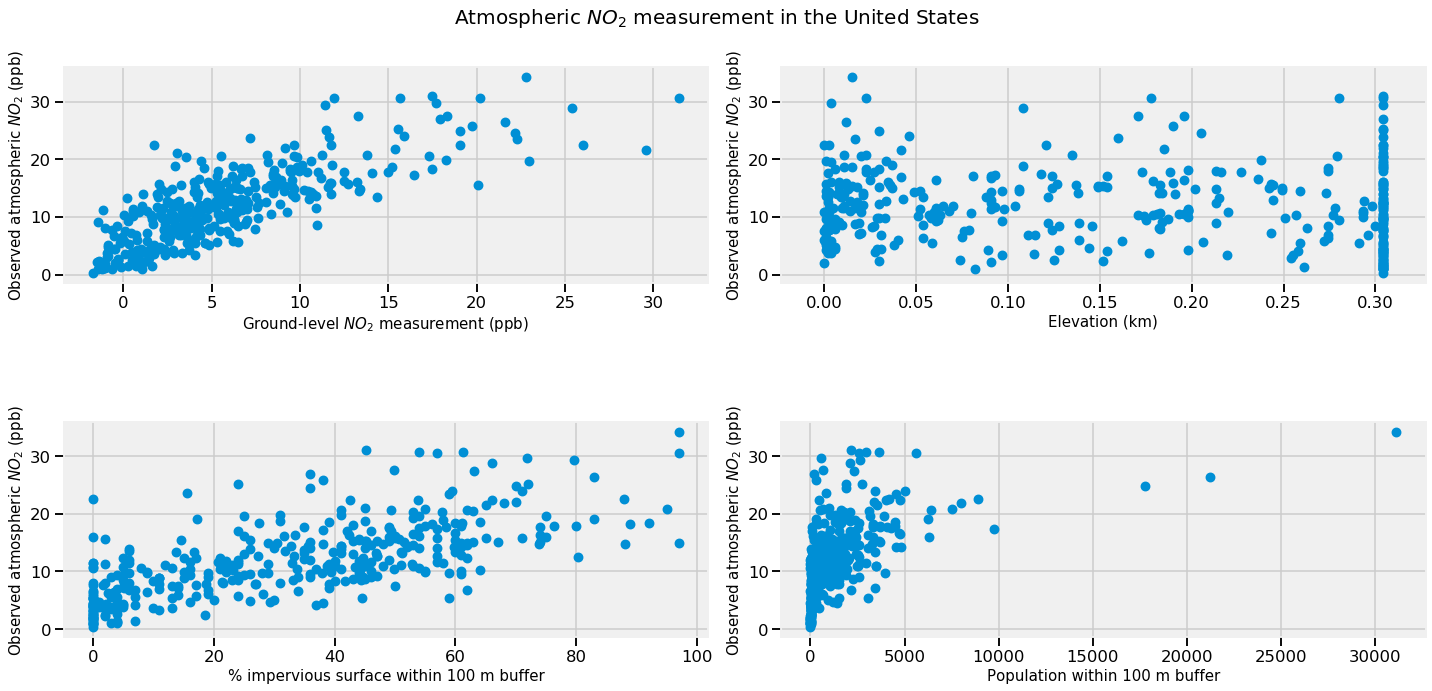

In [10]:
# possible solution
y = df['Observed_NO2_ppb'] # y axis variable
ylab = "Observed atmospheric $NO_2$ (ppb)" # y axis label

msize = 70 # marker size
afsize = 15 # axis font size
tfsize = 20 # title font size

plt.figure(figsize = (20,10))

plt.subplot(221)
plt.scatter(df['WRF+DOMINO'], y, s = msize)
plt.xlabel("Ground-level $NO_2$ measurement (ppb)", fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.subplot(222)
plt.scatter(df['Elevation_truncated_km'], y, s = msize)
plt.xlabel("Elevation (km)", fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.subplot(223)
plt.scatter(df['Impervious_100'], y, s = msize)
plt.xlabel("% impervious surface within 100 m buffer", fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.subplot(224)
plt.scatter(df['Population_100'], y, s = msize)
plt.xlabel("Population within 100 m buffer", fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.suptitle("Atmospheric $NO_2$ measurement in the United States", fontsize = tfsize)

plt.subplots_adjust(top=0.5)
plt.tight_layout()

**Potential answer**: Some observations from the plot above: Ground level $NO_2$ and % impervious surface within 100 m both seem to have a positive correlation with observed atmospheric $NO_2$. Visually, this trend is clearer than it is with population or elevation. From these plots alone, I would expect a feature selection algorithm to prioritize ground-level $NO_2$ and % impervious surface within 100 m over elevation or population within 100 m, but of course it's hard to say how much predictive power these features have compared to the other 100+ potential features.

---

Now that we've loaded the data and done some visual exploration, we can think about how to choose which features to include in the model. Features can provide important information and predictive power. However, as we add more features to the model, we risk increasing its variance (meaning our model performs poorly with test data relative to training data). It also can be harder to make sense of a model with lots of features. Rather than throwing out features entirely, we can turn to a technique called regularization to reduce the variance of our model while still incorporating as much information about the data as possible.

More generally, we can adopt the framework of regularized loss minimization.

$$ \large \hat{\theta} = \arg \min_\theta \frac{1}{n} \sum_{i=1}^n \textbf{Loss}\left(y_i, \hat{y_i}\right) + \lambda \textbf{R}(\theta) $$

The regularization term $\textbf{R}(\theta)$ is essentially a penalty for complex and therefore higher variance models. The regularization parameter $\lambda$ determines the degree of regularization to apply and is typically determined through cross validation.

The two regularlization methods that we're exploring in this lab (Ridge regression and Lasso regression) use different regularization terms $\textbf{R}(\theta)$.

### Section 2: L2 Regularization with Ridge Regression


Ridge regression (L2 regularization) uses the *penalty* term $\large R_{L^2}(\theta) = \sum_{k=1}^p (\theta_k)^2$, where $p$ is the number of model features.

Note that $\lambda$ is a tunable parameter - as the person creating the model, you can choose to increase or decrease $\lambda$ based on how much you want to penalize the addition of model features. The higher the value of $\lambda$, the more a model is penalized for the addition of features. A large $\lambda$ decreases the model's variance at the cost of increasing its bias.

In scikit-learn, the value of $\lambda$ is passed in through the argument `alpha`.

**Question 2.1** Separate the `df_model` dataframe into train and test sets, with 20% of the data in the test set. Set a `random_state` of 1. Begin by setting `X` to the matrix of predictor variables (all quantitative columns in the dataframe except the response variable) and set `y` equal to the response variable `Observed_NO2_ppb`.Then apply `train_test_split` to `X` and `y` to split the data.

In [11]:
# # student version
# from sklearn.model_selection import train_test_split

# X = ...
# y = ...

# X_train, X_test, y_train, y_test = ...

In [12]:
# solution
from sklearn.model_selection import train_test_split

X = df_model.drop(["Observed_NO2_ppb"], axis=1)
y = df_model["Observed_NO2_ppb"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [13]:
#run this to make sure you split the data correctly
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(295, 129) (295,) (74, 129) (74,)


**Question 2.2** Import and create a Ridge regression model with `alpha` value set to 1. Fit the training data into the model, then return a list of the coefficients that the model predicts for each feature in the training data. The [scikit-learn documentation for Ridge()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) is helpful here.

In [14]:
# # student version
# from sklearn.linear_model import Ridge

# ridge = ...
# ridge.fit(...)
# ridge_coefficients = ...

# print(ridge_coefficients)

In [15]:
# solution
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1) #create a Ridge regression object
ridge.fit(X_train, y_train)
ridge_coefficients = ridge.coef_

print(ridge_coefficients)

[ 7.63633147e-01 -3.39086015e-04  6.41601058e+00  3.62895273e-01
 -5.96525472e-01  6.94633513e-01 -4.84745339e-01 -7.17376945e-01
  1.21871875e+00 -9.00683505e-03 -3.47203186e-01 -6.46105921e-01
  9.01544057e-01 -1.03367656e+00  1.44339240e+00 -6.84616896e-01
 -3.03898277e-01  1.24561074e+00 -1.83992670e+00  1.52358687e+00
 -1.35446738e+00  2.48838510e-01  1.59218803e+00 -9.29742402e-01
 -3.00498471e-01  7.16960942e-04 -2.03532469e-03  6.53265092e-03
 -3.98892565e-02  8.88343033e-02 -1.06902144e-01  9.74199105e-02
 -7.53312391e-02  5.33408702e-02 -3.61717090e-02  3.74782234e-02
 -3.31787997e-02  4.89424180e-03  1.32371198e-02 -1.55398442e-02
  1.22254305e-02 -1.63364182e-03 -1.88591138e-02  2.38926178e-02
 -9.02611397e-03  1.78712963e-03 -7.83558083e-04 -7.14749742e-01
  1.11200241e+00 -7.19371359e-01  1.21660473e+00 -5.60169925e-01
 -1.29986497e+00  9.88640554e-01  9.85048466e-02 -3.27286360e-02
 -3.97398170e-02  3.59240457e-01 -4.21479825e-01  1.92113739e-01
 -1.68681747e-01  2.10594

**Question 2.3** Now fit a `LinearRegression` model without regularization and print the resulting list of coefficients.

In [16]:
# student version 
# from sklearn.linear_model import LinearRegression

# lm = ...
# lm.fit(...)
# lm_coefficients = ...

# print(lm_coefficients)

In [17]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
lm_coefficients = lm.coef_

print(lm_coefficients)

[ 7.73313992e-01 -7.69828799e-04  9.59833562e+00  4.47980456e-01
 -8.14145126e-01  9.26378703e-01 -1.80805129e-01 -2.03025164e+00
  3.25168507e+00 -2.37292210e+00  1.68517482e+00 -2.66095616e+00
  3.08952439e+00 -2.88960351e+00  3.54666233e+00 -2.14749368e+00
 -4.53695593e-01  2.92438771e+00 -4.69185202e+00  3.50316696e+00
 -2.04471347e+00  5.02278754e-01  2.11784497e+00 -1.60888192e+00
 -1.00708818e-01  1.36560769e-03 -1.06173342e-03  4.57108694e-04
 -3.04076948e-02  7.53595951e-02 -8.51920549e-02  7.01827669e-02
 -5.44495319e-02  4.31976312e-02 -3.37689185e-02  3.83845957e-02
 -3.02379127e-02  1.39224438e-03  1.40374809e-02 -1.60961421e-02
  1.59181610e-02 -8.47356329e-03 -1.25415826e-02  2.04806776e-02
 -1.05351279e-02  4.49371937e-03 -1.52138855e-03 -2.22803886e+00
  2.12681965e+00 -1.65268565e+00  1.88535220e+00 -5.35015794e-01
 -1.73258544e+00  1.20013096e+00  1.31888641e-01 -6.93620237e-02
 -5.65933126e-02  4.03967749e-01 -4.40819719e-01  1.84521277e-01
 -1.72469211e-01  2.19278

**Question 2.4** Run the code below to generate a bar chart that shows the coefficient values from simple linear regression in blue, and from ridge regression in red. Then, in the markdown cell below, comment on the results. Can you explain your observations based on your understanding of L2 ridge regression?

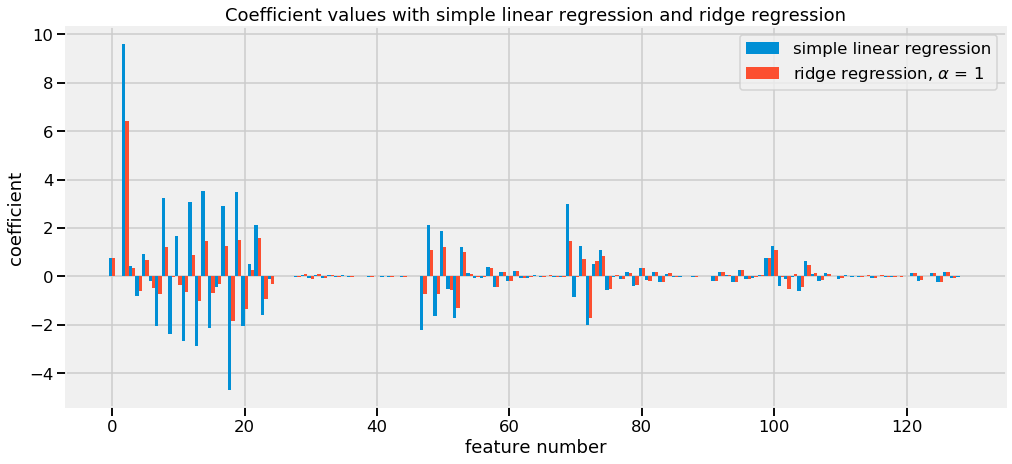

In [18]:
# run this cell
ind = np.arange(len(lm_coefficients))
width = 0.5

plt.figure(figsize = (15,7))

plt.bar(ind-(width/2), width = width, height = lm_coefficients, label = "simple linear regression")
plt.bar(ind+(width/2), width = width, height = ridge_coefficients, label = r"ridge regression, $\alpha$ = 1")
plt.xlabel("feature number")
plt.ylabel("coefficient")
plt.title("Coefficient values with simple linear regression and ridge regression")
plt.legend()
plt.show()

*Your answer here*

**Possible answer:** We can see the Ridge is indeed forcing the coefficients closer to zero, relative to linear regression.

**Question 2.5**: We just observed how the Ridge Regression model generates coefficients when `alpha` is set to one. Complete the following code which generalizes the fitting and predicting process we just did in Question 2.3 for various values of `alpha`.

Then calculates the mean squared error (MSE) between our predictions and the test dataset. The MSE in this case is a measure of the accuracy of our predictions.

In [19]:
# # student version
# from sklearn.metrics import mean_squared_error
# alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
# mses = []

# for a in alphas:
#     model = ...
#     model.fit(...)
#     y_pred = model.predict(...)
#     mses.append(mean_squared_error(y_pred, y_test))

# print(mses)

# a_log = np.log10(alphas)

# plt.figure(figsize = (15,5))
# sns.barplot(a_log, mses, color = 'cadetblue')
# plt.xlabel(r'$log_{10}(\alpha)$')
# plt.ylabel('MSE')
# plt.title('Ridge regression MSE for each value of alpha');

[16.64681830306923, 16.582872445901543, 16.576166388375427, 16.226275726098322, 15.154989058128194, 15.06742089488353, 18.98069484736395, 19.77241596213604, 17.710328244564348, 16.567607252742263, 16.39154500703378, 17.48213513743568]


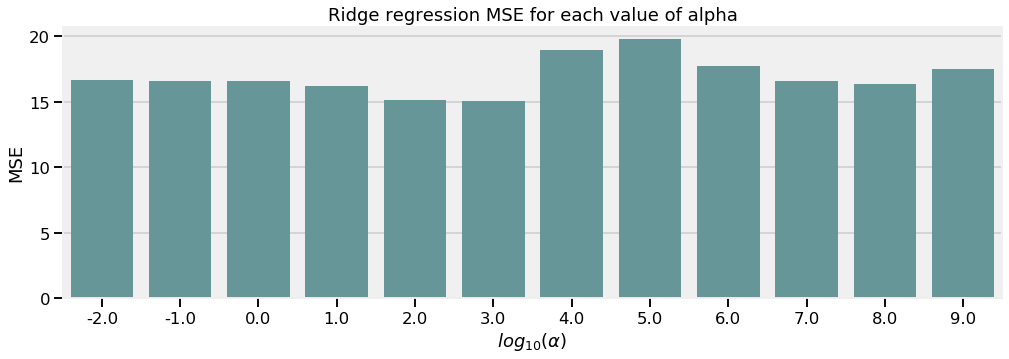

In [20]:
from sklearn.metrics import mean_squared_error
alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
mses = []

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mses.append(mean_squared_error(y_pred, y_test))

print(mses)

a_log = np.log10(alphas)
plt.figure(figsize = (15,5))
sns.barplot(a_log, mses, color = 'cadetblue')
plt.xlabel(r'$log_{10}(\alpha)$')
plt.ylabel('MSE')
plt.title('Ridge regression MSE for each value of alpha');

**Question 2.6** What is the lowest MSE observed and which value of alpha did it come from? What value of $\lambda$ does that correspond to? Does the value of $\lambda$ that minimizes MSE more heavily or less heavily penalize additional coefficients than our initial value of $\lambda$ that we used to produce the plot in question 2.4?

In [21]:
# student version
# Your code here

*Your answer here*

In [22]:
# solution
print("lowest MSE:", np.min(mses), "; alpha:", alphas[np.argmin(mses)]) #"; lambda:", 1/alphas[np.argmin(mses)])

lowest MSE: 15.06742089488353 ; alpha: 1000.0


**Question 2.7** How does ridge regression with the value of `alpha` identified in question 2.6 perform relative to simple linear regression with respect to the mean squared error?

In [23]:
# student version
# Your code here

*Your answer here*

In [24]:
# possible solution
print("linear model MSE:", mean_squared_error(lm.predict(X_test), y_test))
print("ridge regression minimum MSE:", np.min(mses))

linear model MSE: 16.66054589135216
ridge regression minimum MSE: 15.06742089488353


### Section 3: L1 Regularization with Lasso Regression

While ridge regression minimizes coefficients, it incorporates *all* the features into your model. It won't actually drive any coefficients to 0 (unless $\lambda$ = $\infty$!). This can make your model less *interpretable* - for instance, in the case of the model we created in Section 2, we have over 130 non-zero coefficients and thus over 130 features.

Lasso regression (also called L1 Regularization) avoids the issue of including too many unimportant variables by using a model formulation that can drive some coefficients to 0.

Lasso regression uses the *penalty* term $\large R_{L^1}(\theta) = \sum_{k=1}^p \Big|\theta_k\Big|$, where $p$ is the number of model features.

**Question 3.1** Let's repeat the steps we did above for Ridge Regression, this time for Lasso Regression. Create a Lasso model with an `alpha` of 1 and fit on the X_train and y_train dataset.

In [25]:
# # student version
# from sklearn.linear_model import Lasso

# lasso = ...
# lasso.fit(...)
# lasso_coefficients = ...
# print(lasso_coefficients)

In [26]:
# solution
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_coefficients = lasso.coef_
print(lasso_coefficients)

[ 6.37243194e-01 -3.73686902e-05  0.00000000e+00  1.73252001e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.26102452e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -6.56838725e-04  9.44308666e-05 -9.54545795e-04
 -8.63661882e-04  6.00742099e-05 -1.23641671e-04 -7.72547622e-05
  2.93758775e-04  3.03265110e-03  1.19371490e-03  1.00895502e-04
 -7.99284262e-04 -4.59602525e-04 -0.00000000e+00  1.81013572e-04
 -6.71353110e-04 -9.26496660e-04 -9.63606391e-05  6.02929416e-04
 -5.61455220e-04  1.61164011e-04  8.71205417e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.08890727e-01  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000

**Question 3.2** Output a plot that shows the coefficients from the simple linear regression in part 2, the ridge regression in part 2, and the lasso regression above side-by-side. You can adapt the code from question 2.4 or write your own.

In [27]:
# student version
# Your code here

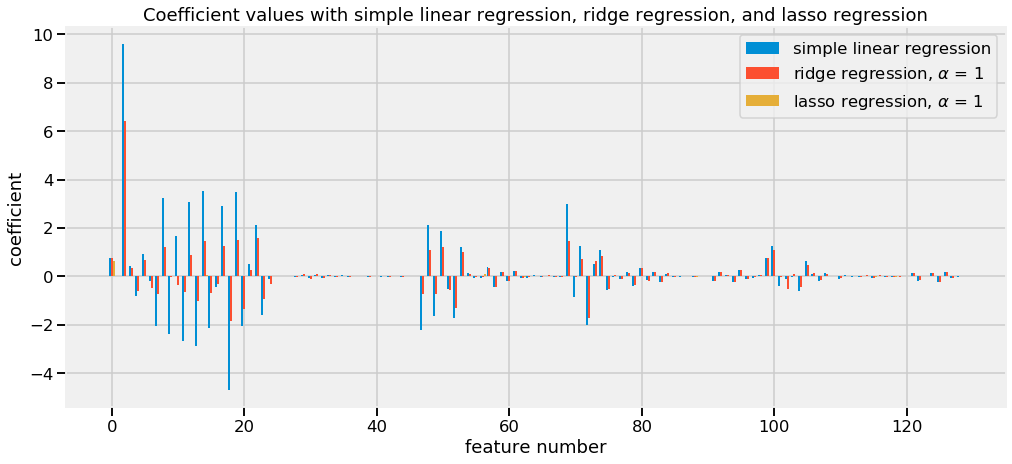

In [28]:
# run this cell
ind = np.arange(len(lm_coefficients))
width = 0.3

plt.figure(figsize = (15,7))

plt.bar(ind-width, width = width, height = lm_coefficients, label = "simple linear regression")
plt.bar(ind, width = width, height = ridge_coefficients, label = r"ridge regression, $\alpha$ = 1")
plt.bar(ind+width, width = width, height = lasso_coefficients, label = r"lasso regression, $\alpha$ = 1")
plt.xlabel("feature number")
plt.ylabel("coefficient")
plt.title("Coefficient values with simple linear regression, ridge regression, and lasso regression")
plt.legend()
plt.show()

**Question 3.3:** Comment on the results in question 3.2. Can you explain your observations based on your understanding of L1 lasso regression?

*Your answer here*

**Question 3.4** What proportion of the datasets features are "ignored" by this lasso model? What are the column names of the features that are **not** ignored by this lasso model?

In [29]:
# student version
# Your code here

In [30]:
# solution
prop_ignored = 1 - (np.count_nonzero(lasso_coefficients) / len(lasso_coefficients))
print("proportion of features ignored:", prop_ignored)

cols_included = X.columns[lasso_coefficients != 0]
print("columns included:", cols_included)

proportion of features ignored: 0.6124031007751938
columns included: Index(['WRF+DOMINO', 'Distance_to_coast_km', 'Impervious_100',
       'Impervious_1800', 'Population_100', 'Population_200', 'Population_300',
       'Population_400', 'Population_500', 'Population_600', 'Population_700',
       'Population_800', 'Population_1000', 'Population_1200',
       'Population_1500', 'Population_1800', 'Population_2000',
       'Population_3000', 'Population_3500', 'Population_4000',
       'Population_5000', 'Population_6000', 'Population_7000',
       'Population_8000', 'Population_10000', 'Major_1200', 'Major_3500',
       'Major_7000', 'Major_10000', 'Resident_3500', 'Resident_5000',
       'Resident_7000', 'Resident_8000', 'Resident_10000', 'Resident_10500',
       'Resident_11000', 'Resident_12500', 'Resident_13000', 'Resident_13500',
       'Resident_14000', 'total_4000', 'total_6000', 'total_7000',
       'total_8000', 'total_10000', 'total_11500', 'total_12000',
       'total_12500',

**Question 3.5**: Look back to the features you plotted in question 1.3. Were any of those features ignored or included by the lasso model?

*Your answer here*

**Question 3.6**: Remember how we calculated the test MSE for different values of $\alpha$ in question 2.5? Now, we're going to write a function that automates that process, taking as input a list of alphas `alphas` and a model (`Ridge` or `Lasso`). Complete the function below, and then define a list of alphas and call the function using the `Lasso` model to return a list of MSEs.

In [31]:
# # student version

# def calculate_mses(alphas, Model):
#     """
#     Input:
#         alphas (array): contains floats of various alpha values
#         Model (sklearn model): the type of sklearn model on which to fit the data
#     Output:
#         an array of floats containing the mean-squared-errors from the predictions
#     """
#     mses = []

#     for a in alphas:
#         # Your code here
        
#     return mses

In [32]:
def calculate_mses(alphas, Model):
    """
    Input:
        alphas (array): contains floats of various alpha values
        Model (sklearn model): the type of sklearn model on which to fit the data
    Output:
        an array of floats containing the mean-squared-errors from the predictions
    """
    mses = []

    for a in alphas:
        model = Model(alpha=a)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mses.append(mean_squared_error(y_pred, y_test))
        
    return mses

In [33]:
lasso_mses = calculate_mses(alphas, Lasso)
lasso_mses

[11.879421610398364,
 11.219692369740818,
 11.141121125728707,
 17.85270128090843,
 16.782210880120438,
 17.128973428493417,
 44.84545932741483,
 44.84545932741483,
 44.84545932741483,
 44.84545932741483,
 44.84545932741483,
 44.84545932741483]

**Question 3.7**: How well does the Lasso Regression model perform against the Ridge Regression model from before? Calculate the ridge MSEs and the lasso MSEs using the same set of `alphas` then plot the two series against each other using whatever type of plot makes the most sense.

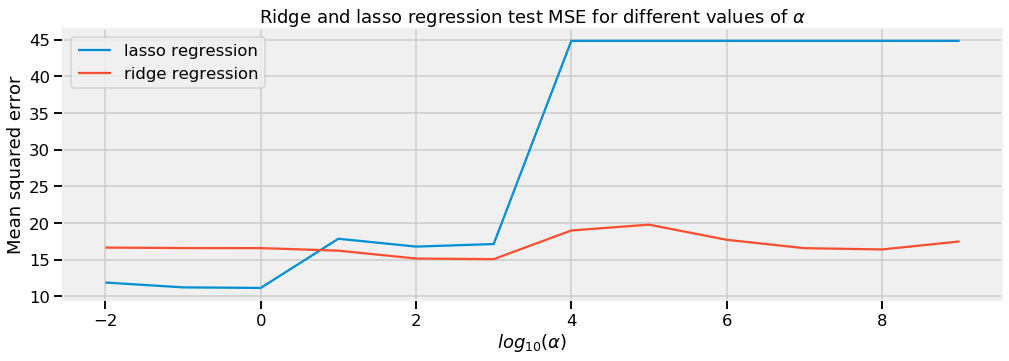

In [34]:
lasso_mses = calculate_mses(alphas, Lasso)
ridge_mses = calculate_mses(alphas, Ridge)

plt.figure(figsize = (15,5))
plt.plot(np.log10(alphas),lasso_mses, label=r"lasso regression")
plt.plot(np.log10(alphas), ridge_mses, label=r"ridge regression")
plt.xlabel(r"$log_{10}(\alpha)$")
plt.ylabel("Mean squared error")
plt.title(r'Ridge and lasso regression test MSE for different values of $\alpha$');
plt.legend();

**Question 3.8** Explain the plot we generated above. Which model performs more consistently on the test data across various values of alpha? Why might this be the case?

*Your answer here*

# Hooray, you're done! 

Please remember to submit your lab work, after clicking Kernel -> Restart & Run All, in .html and .ipynb format on bCourses.

Further Reading:

Regularization - https://www.textbook.ds100.org/ch/16/reg_intro.html
    
Notebook developed by Alex McMurry, Kevin Marroquin, and Melissa Ly

Data Science Modules: http://data.berkeley.edu/education/modules